In [296]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron as Perceptron_SKLearn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, RocCurveDisplay, roc_curve, classification_report, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

In [188]:
# import data preprocessed
with open("diabetes_scale.txt", "r+") as file:
    data = []
    for i in range(768):
        line = file.readline()
        line = line[:-1]
        data.append([line])

# split into columns
data1 = []
for row in data:
    data1.append(row[0].split())

# take only the numbers after ':' in each column and convert to numeric (int and float)
data2 = []
for row in data1:
    new_col = []
    row1 = row[1:]
    new_col.append(int(row[0]))
    for col in row1:
        new_col.append(float(col[2:]))
    data2.append(new_col)

# clean data to separate missing values
data3 = []
for row in data2:
    if len(row) == 9:
        data3.append(row)

#split data into target and features
data4 = np.array(data3)
y = data4[:,:1]
x = data4[:,1:]

Outcome
 1.0    496
-1.0    263
Name: count, dtype: int64

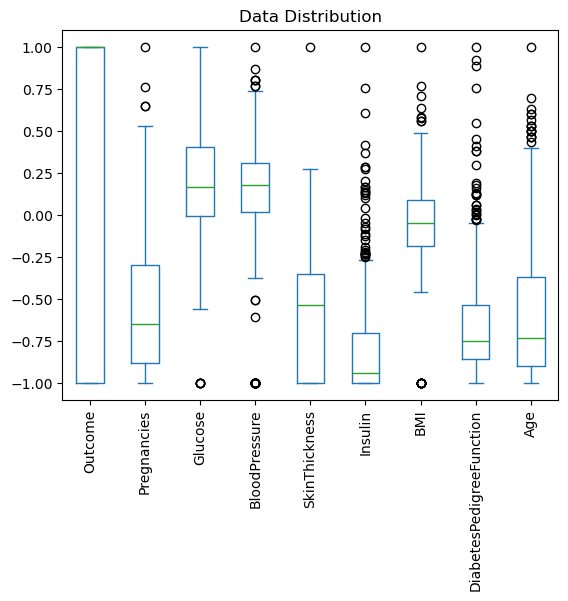

In [254]:
# data summary
data_summary = pd.DataFrame(data4)
data_summary.columns = [
    'Outcome',
    'Pregnancies',
    'Glucose',
    'BloodPressure',
    'SkinThickness',
    'Insulin',
    'BMI',
    'DiabetesPedigreeFunction',
    'Age'
]
data_summary.describe()
data_summary.plot.box(rot=90).set_title("Data Distribution")
data_summary["Outcome"].value_counts()

In [77]:
#split data into train and test (70:30)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 123)

In [78]:
# Configure to correct sizes

# n = number of features
# m = number of observations

# dimension for x should be (n,m)
X_test = x_test.T
X_train = x_train.T

# dimension for y should be (1, m)
Y_test = y_test.T
Y_train = y_train.T

# dimension for w is (n,1)
# dimension for b is (1,1)

In [306]:
# Perceptron object
class Perceptron:
    def __init__(self, activation_fn="sign", loss_fn="perceptron", eta=0.01):
        self.W = 0
        self.b = 0
        self.X_train = 0
        self.Y_train = 0
        self.Y_pred = 0
        self.train_acc_list = []
        self.validation_acc_list = []
        self.loss_list = []
        self.activation_fn = activation_fn
        self.loss_fn = loss_fn
        self.eta = eta
        self.W_history = []
        self.b_history = []

    def __initialise_parameters(self):
        np.random.seed(123)
        self.W = np.random.rand(8,1)
        np.random.seed(123)
        self.b = np.random.rand()
        self.W_history = []
        self.b_history = []

    def __z(self, input):
        return self.W.T@input + self.b

    def __indicator(self, target, input): 
        return np.where(z(input, self.W, self.b)*target < 0, 1, 0)

    def __perceptron_loss(self):
        Y = self.Y_train
        X = self.X_train
        Y_pred = np.sign(self.__z(X))
        t_dot_p = -Y*Y_pred
        zeros = np.zeros(Y.shape[1]).reshape(1, Y.shape[1])
        return np.sum(np.max(np.vstack([zeros, t_dot_p]),axis=0))/Y.shape[1]

    def __perceptron_update(self):
        Y = self.Y_train
        X = self.X_train
        self.W += self.eta*(1/Y.shape[1])*X@(Y*self.__indicator(Y, X)).T
        self.b += self.eta*(1/Y.shape[1])*np.sum(Y*self.__indicator(Y, X))

    def __zero_one_loss(self):
        X = self.X_train
        Y = self.Y_train
        Y_pred = np.sign(self.__z(X))
        return np.sum(np.where(Y_pred*Y<0,1,0))/Y.shape[1]

    def __error_update(self):
        Y = self.Y_train
        X = self.X_train
        self.W += self.eta*(1/Y.shape[1])*X@(Y - np.sign(self.__z(X))).T
        self.b += self.eta*(1/Y.shape[1])*np.sum(Y - np.sign(self.__z(X))).T

    def __determine_loss_fn(self):
        match self.loss_fn:
            case "perceptron":
                return self.__perceptron_loss, self.__perceptron_update
            case "zero_one":
                return self.__zero_one_loss, self.__error_update
    
    def get_parameters(self):
        return self.W, self.b

    def fit(self, target, input, epochs = 1000, eta=0.01):
        self.X_train = input
        self.Y_train = target
        self.eta = eta
        X = self.X_train
        Y = self.Y_train
        loss_fn, update_fn = self.__determine_loss_fn()
        self.__initialise_parameters()
        print("Training with sign activation function and ", self.loss_fn, " loss function.")
        print("The initial loss is: ", loss_fn())
        for i in range(epochs):
            update_fn()
            self.W_history.append(self.W)
            self.b_history.append(self.b)
            Y_pred = np.sign(self.__z(X))
            self.train_acc_list.append(accuracy_score(Y.flatten(), Y_pred.flatten()))
            self.loss_list.append(loss_fn())
        print("The post-training loss is: ", loss_fn())
        print("Perceptron Training Accuracy:", accuracy_score(Y.flatten(), Y_pred.flatten()))

    def predict(self, input):
        Y_pred = np.sign(self.__z(input))
        self.Y_pred = Y_pred
        return Y_pred

    def plot_accuracy_v_loss(self):
        plt.figure()
        plt.plot(self.train_acc_list, label="Accuracy")
        plt.plot(self.loss_list, label="Loss")
        plt.xlabel("Iterations")
        plt.ylabel("Accuracy/Loss")
        plt.title("Accuracy vs Loss")
        plt.legend(loc="upper left")

    def plot_training_v_validation_accuracy(self):
        self.validation_acc_list = []            
        plt.figure()
        plt.plot(self.train_acc_list, label="Accuracy")
        plt.plot(self.loss_list, label="Loss")
        plt.xlabel("Iterations")
        plt.ylabel("Accuracy/Loss")
        plt.title("Accuracy vs Loss")
        plt.legend(loc="upper left")

    def display_confusion_matrix(self, target):
        conf_mat = confusion_matrix(target.flatten(), self.Y_pred.flatten(), labels=[-1,1])
        disp = ConfusionMatrixDisplay(conf_mat, display_labels=[-1,1])
        disp.plot()

    def display_classification_report(self, target):
        print(classification_report(target.flatten(), self.Y_pred.flatten(),labels=[-1,1],target_names=["Diabetes", "No Diabetes"]))

    def display_classification_metrics(self, target):
        print("Accuracy: ", accuracy_score(target.flatten(), self.Y_pred.flatten()))
        print("f1: ", f1_score(target.flatten(), self.Y_pred.flatten(), pos_label=-1))
        print("Precision: ", precision_score(target.flatten(), self.Y_pred.flatten(), pos_label=-1))
        print("Recall: ", recall_score(target.flatten(), self.Y_pred.flatten(), pos_label=-1))
        self.display_confusion_matrix(target)
        
        

Training with sign activation function and  zero_one  loss function.
The initial loss is:  0.6685499058380414
The post-training loss is:  0.2542372881355932
Perceptron Training Accuracy: 0.7457627118644068
Accuracy:  0.7587719298245614
f1:  0.6308724832214765
Precision:  0.6811594202898551
Recall:  0.5875
              precision    recall  f1-score   support

    Diabetes       0.68      0.59      0.63        80
 No Diabetes       0.79      0.85      0.82       148

    accuracy                           0.76       228
   macro avg       0.74      0.72      0.73       228
weighted avg       0.75      0.76      0.75       228



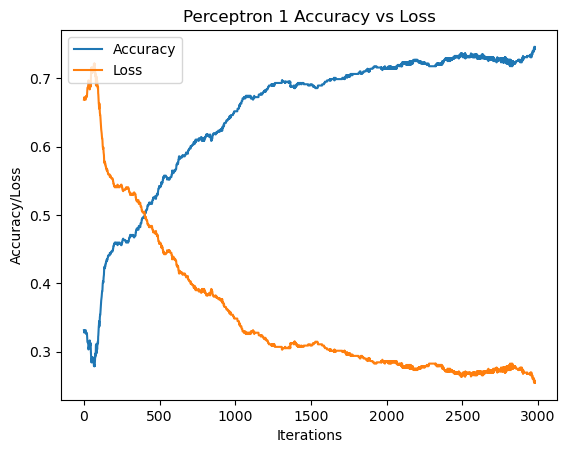

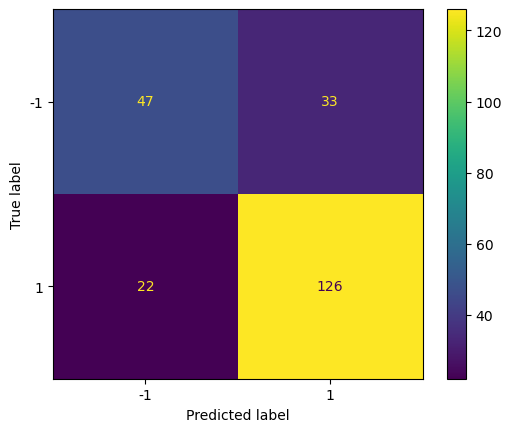

In [315]:
perceptron = Perceptron(loss_fn="zero_one")
perceptron.fit(Y_train, X_train, 2980, 0.005) 
perceptron.predict(X_test)
perceptron.plot_accuracy_v_loss()
plt.title("Perceptron 1 Accuracy vs Loss")
perceptron.display_classification_metrics(Y_test)
perceptron.display_classification_report(Y_test)

Training with sign activation function and  perceptron  loss function.
The initial loss is:  0.6685499058380414
The post-training loss is:  0.2730696798493409
Perceptron Training Accuracy: 0.7269303201506592
Accuracy:  0.7543859649122807
f1:  0.6111111111111112
Precision:  0.6875
Recall:  0.55
              precision    recall  f1-score   support

    Diabetes       0.69      0.55      0.61        80
 No Diabetes       0.78      0.86      0.82       148

    accuracy                           0.75       228
   macro avg       0.73      0.71      0.72       228
weighted avg       0.75      0.75      0.75       228



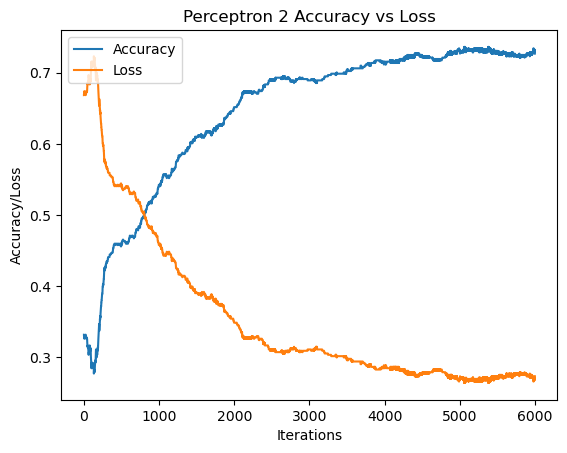

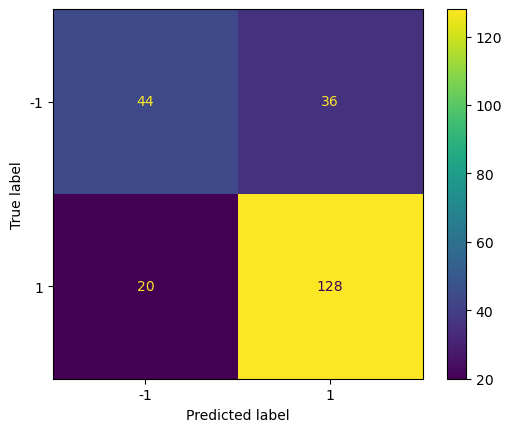

In [316]:
perceptron_2 = Perceptron(loss_fn="perceptron")
perceptron_2.fit(Y_train, X_train, 6000, 0.005) 
perceptron_2.predict(X_test)
perceptron_2.plot_accuracy_v_loss()
plt.title("Perceptron 2 Accuracy vs Loss")
perceptron_2.display_classification_metrics(Y_test)
perceptron_2.display_classification_report(Y_test)

              precision    recall  f1-score   support

    Diabetes       0.70      0.09      0.16        80
 No Diabetes       0.67      0.98      0.79       148

    accuracy                           0.67       228
   macro avg       0.68      0.53      0.47       228
weighted avg       0.68      0.67      0.57       228



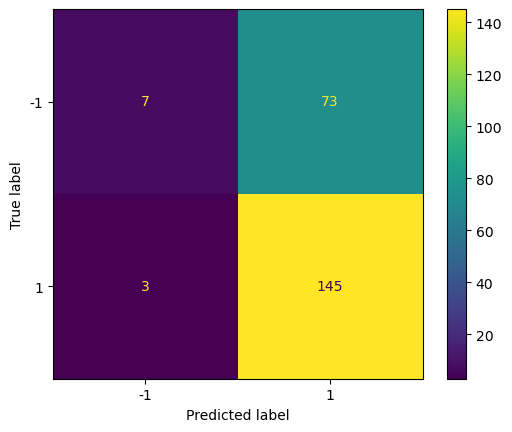

In [314]:
# Perceptron in scikit-learn
perceptron = Perceptron_SKLearn(max_iter=5000, eta0=0.005)
perceptron.fit(X_train.T, Y_train.flatten())
Y_pred_perceptron_sklearn = perceptron.predict(X_test.T)
conf_mat_perceptron_sklearn = confusion_matrix(Y_test.flatten(), Y_pred_perceptron_sklearn, labels=[-1,1])
ConfusionMatrixDisplay(conf_mat_perceptron_sklearn, display_labels=[-1,1]).plot()
print(classification_report(Y_test.flatten(), Y_pred_perceptron_sklearn,labels=[-1,1],target_names=["Diabetes", "No Diabetes"]))

              precision    recall  f1-score   support

    Diabetes       0.72      0.51      0.60        80
 No Diabetes       0.77      0.89      0.83       148

    accuracy                           0.76       228
   macro avg       0.75      0.70      0.71       228
weighted avg       0.75      0.76      0.75       228



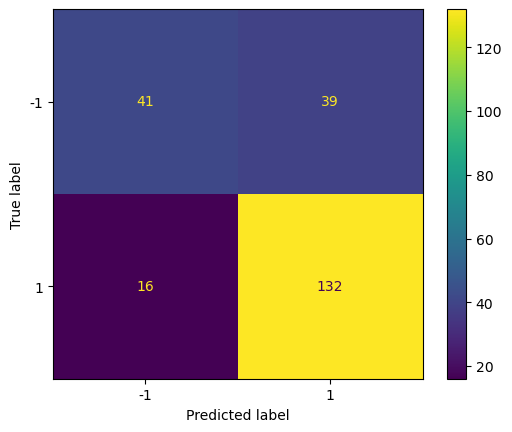

In [170]:
# Logistic Regression
logistic_reg = LogisticRegression(random_state=123, penalty=None)
logistic_reg.fit(X_train.T,Y_train.flatten())
Y_pred_lr = logistic_reg.predict(X_test.T)
conf_mat_lr = confusion_matrix(Y_test.flatten(), Y_pred_lr, labels=[-1,1])
ConfusionMatrixDisplay(conf_mat_lr, display_labels=[-1,1]).plot()
print(classification_report(Y_test.flatten(), Y_pred_lr,labels=[-1,1],target_names=["Diabetes", "No Diabetes"]))

              precision    recall  f1-score   support

    Diabetes       0.59      0.56      0.58        80
 No Diabetes       0.77      0.79      0.78       148

    accuracy                           0.71       228
   macro avg       0.68      0.68      0.68       228
weighted avg       0.71      0.71      0.71       228



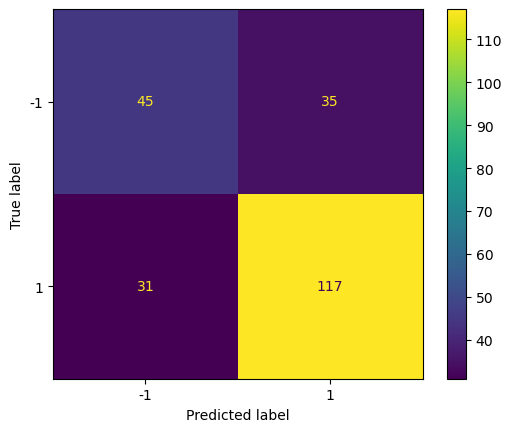

In [178]:
# Decision Tree
dec_tree = DecisionTreeClassifier(random_state=123)
dec_tree.fit(X_train.T, Y_train.flatten())
Y_pred_dt = dec_tree.predict(X_test.T)
conf_mat_dt = confusion_matrix(Y_test.flatten(), Y_pred_dt, labels=[-1,1])
ConfusionMatrixDisplay(conf_mat_dt, display_labels=[-1,1]).plot()
print(classification_report(Y_test.flatten(), Y_pred_dt,labels=[-1,1],target_names=["Diabetes", "No Diabetes"]))

              precision    recall  f1-score   support

    Diabetes       0.73      0.51      0.60        80
 No Diabetes       0.77      0.90      0.83       148

    accuracy                           0.76       228
   macro avg       0.75      0.71      0.72       228
weighted avg       0.76      0.76      0.75       228



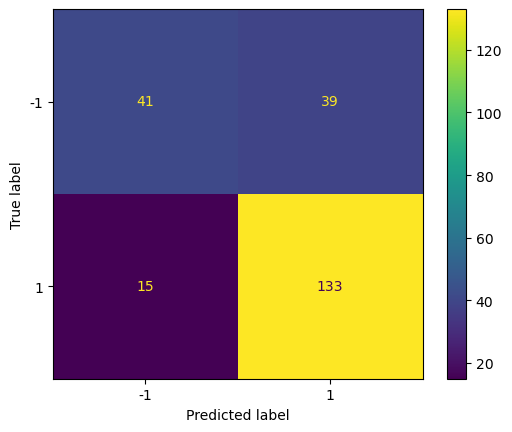

In [179]:
# Random Forest
random_forest = RandomForestClassifier(random_state=123)
random_forest.fit(X_train.T, Y_train.flatten())
Y_pred_rf = random_forest.predict(X_test.T)
conf_mat_rf = confusion_matrix(Y_test.flatten(), Y_pred_rf, labels=[-1,1])
ConfusionMatrixDisplay(conf_mat_rf, display_labels=[-1,1]).plot()
print(classification_report(Y_test.flatten(), Y_pred_rf,labels=[-1,1],target_names=["Diabetes", "No Diabetes"]))

C:\Users\Putra\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

    Diabetes       0.74      0.50      0.60        80
 No Diabetes       0.77      0.91      0.83       148

    accuracy                           0.76       228
   macro avg       0.76      0.70      0.71       228
weighted avg       0.76      0.76      0.75       228



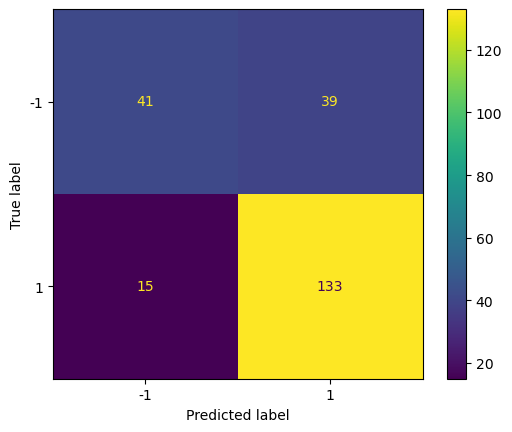

In [182]:
# SVM
svm = LinearSVC(random_state=123)
svm.fit(X_train.T, Y_train.flatten())
Y_pred_svm = svm.predict(X_test.T)
conf_mat_svm = confusion_matrix(Y_test.flatten(), Y_pred_rf, labels=[-1,1])
ConfusionMatrixDisplay(conf_mat_rf, display_labels=[-1,1]).plot()
print(classification_report(Y_test.flatten(), Y_pred_svm,labels=[-1,1],target_names=["Diabetes", "No Diabetes"]))